In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

path_train = "C:/Users/user/Downloads/capsule.tar/capsule/capsule/train/good/*.png"
path_test = "C:/Users/user/Downloads/capsule.tar/capsule/capsule/test/crack/*.png"

train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [58]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

4/4 [=] - 2s 574ms/step - loss: 4.9132e-04


In [59]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, './')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}

df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

   Filename  instance_score  is_outlier
1   001.png        0.003192           1
10  010.png        0.001393           1


In [57]:
print(df)

   Filename  instance_score  is_outlier
0   000.png        0.000195           0
1   001.png        0.003187           1
2   002.png        0.000449           0
3   003.png        0.000454           0
4   004.png        0.000677           0
5   005.png        0.000211           0
6   006.png        0.000383           0
7   007.png        0.000171           0
8   008.png        0.000218           0
9   009.png        0.000304           0
10  010.png        0.001394           1
11  011.png        0.000679           0
12  012.png        0.000531           0
13  013.png        0.000243           0
14  014.png        0.000308           0
15  015.png        0.000196           0
16  016.png        0.000195           0
17  017.png        0.000391           0
18  018.png        0.000324           0
19  019.png        0.000738           0
20  020.png        0.000595           0
21  021.png        0.000718           0
22  022.png        0.000234           0


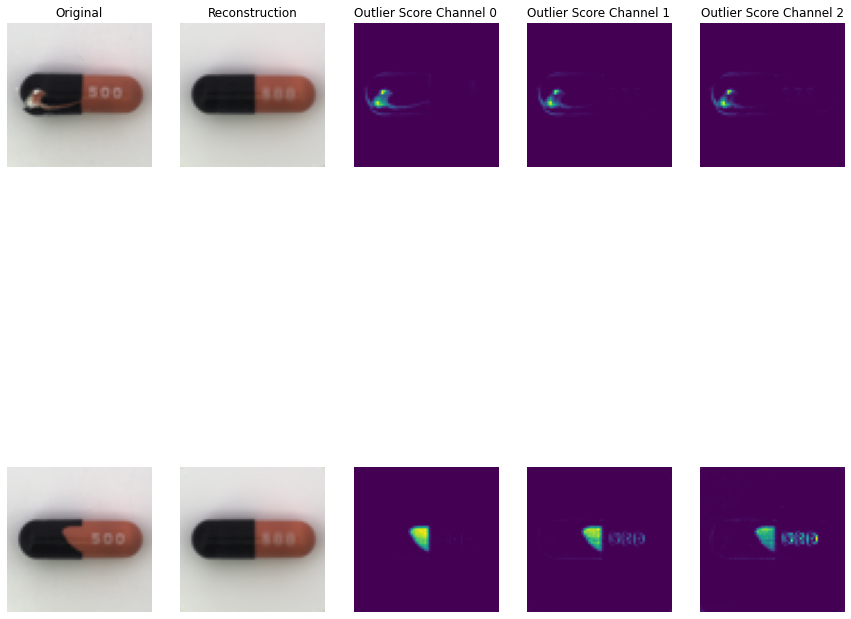

In [60]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))

In [61]:
# cracked image가 23개임에도 불구하고, 2개밖에 추출해내지 못했다.
# threshold를 변경해서 다시 학습해보자

In [62]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

4/4 [=] - 2s 540ms/step - loss: 4.6132e-04


In [67]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, './')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}

df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]
print(df)
print(df_outliers)

   Filename  instance_score  is_outlier
0   000.png        0.000181           0
1   001.png        0.003174           1
2   002.png        0.000441           0
3   003.png        0.000428           0
4   004.png        0.000671           0
5   005.png        0.000195           0
6   006.png        0.000375           0
7   007.png        0.000162           0
8   008.png        0.000214           0
9   009.png        0.000290           0
10  010.png        0.001378           1
11  011.png        0.000664           0
12  012.png        0.000503           0
13  013.png        0.000227           0
14  014.png        0.000292           0
15  015.png        0.000180           0
16  016.png        0.000182           0
17  017.png        0.000383           0
18  018.png        0.000324           0
19  019.png        0.000726           0
20  020.png        0.000592           0
21  021.png        0.000705           0
22  022.png        0.000217           0
   Filename  instance_score  is_outlier


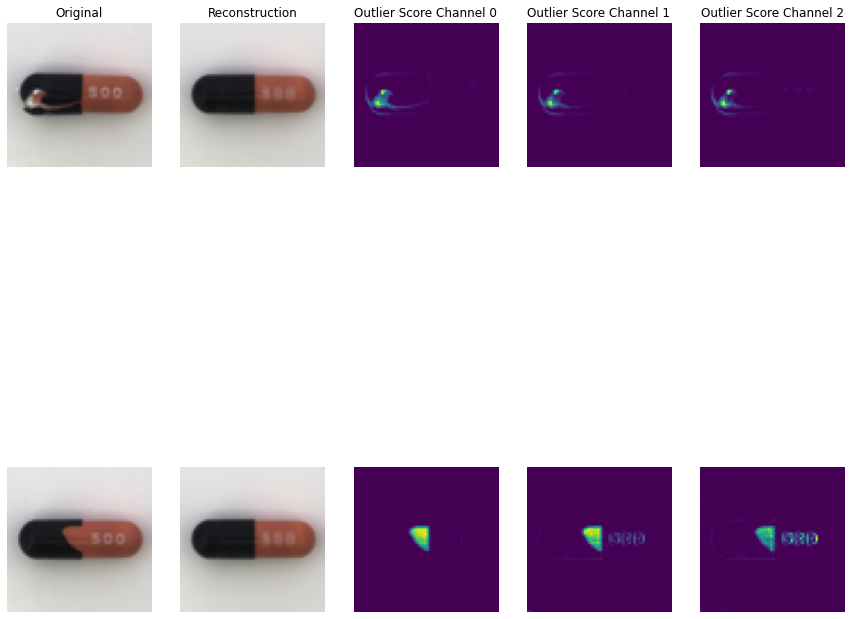

In [69]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))